In [15]:
import json


with open('wave_results_n_[2]_avg.json') as file:
    data = json.load(file)

best_relu_setups = {}


for experiment, details in data.items():
    if all(details['training_info']['is_converged_values']):  # Check if all runs converged
        n_modes = details['branch_config']['dense_layer']['layer_width']
        activation = details['branch_config']['dense_layer']['activation']


        iteration_losses = [value for key, value in details['training_info'].items() 
                            if key.startswith('iteration_') and key.endswith('_loss')]
        min_loss = min(iteration_losses) if iteration_losses else float('inf')

  
        if activation == 'tanh':
            if n_modes not in best_relu_setups or min_loss < best_relu_setups[n_modes]['best_loss']:
                best_relu_setups[n_modes] = {
                    'best_loss': min_loss,
                    'parameters': details['branch_config']
                }

for width, setup in best_relu_setups.items():
    print(f"Layer Width: {width}")
    print(f"Best Loss: {setup['best_loss']}")
    print("Parameters:")
    for key, value in setup['parameters'].items():
        print(f"  {key}: {value}")
    print("\n")


Layer Width: 256
Best Loss: 0.004055696260023021
Parameters:
  dense_layer: {'layer_width': 256, 'activation': 'tanh', 'parameter_sampler': 'tanh'}
  linear_layer: {'regularization_scale': 1e-10}


Layer Width: 512
Best Loss: 0.004055696259952233
Parameters:
  dense_layer: {'layer_width': 512, 'activation': 'tanh', 'parameter_sampler': 'tanh'}
  linear_layer: {'regularization_scale': 1e-10}


Layer Width: 1024
Best Loss: 0.004055696259892899
Parameters:
  dense_layer: {'layer_width': 1024, 'activation': 'tanh', 'parameter_sampler': 'tanh'}
  linear_layer: {'regularization_scale': 1e-10}


Layer Width: 2048
Best Loss: 0.004055696259846015
Parameters:
  dense_layer: {'layer_width': 2048, 'activation': 'tanh', 'parameter_sampler': 'tanh'}
  linear_layer: {'regularization_scale': 1e-08}




In [9]:
best_losses_relu

{}

In [8]:
best_losses_tanh

{256: 1.4616754631543076e-12,
 512: 1.1165831137189832e-12,
 1024: 8.514260414794644e-13,
 2048: 5.104001072509713e-13}

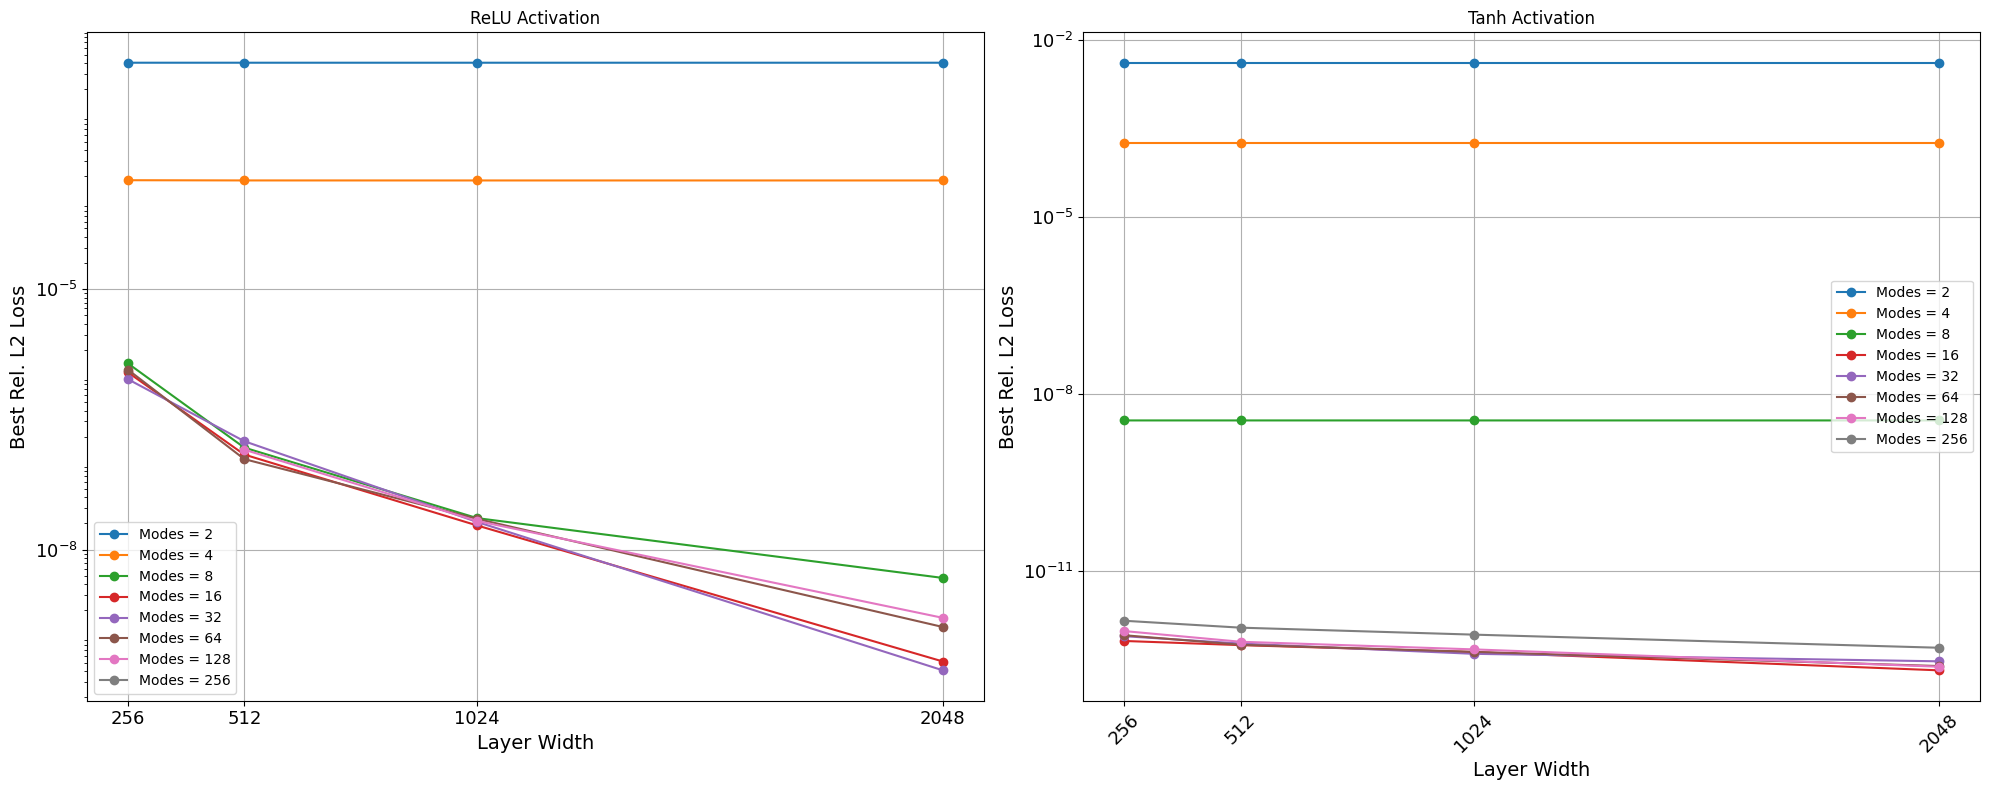

In [83]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker


file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]

def process_file(file_name, activation_function):
    best_losses = {}
    with open(file_name) as file:
        data = json.load(file)
    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']) and details['branch_config']['dense_layer']['activation'] == activation_function:
            layer_width = details['branch_config']['dense_layer']['layer_width']
            iteration_losses = [value for key, value in details['training_info'].items() if key.startswith('iteration_') and key.endswith('_loss')]
            min_loss = min(iteration_losses) if iteration_losses else float('inf')
            if layer_width not in best_losses or min_loss < best_losses[layer_width][0]:
                best_losses[layer_width] = (min_loss, experiment)
    return best_losses

class CustomLogFormatter(mticker.LogFormatter):
    def __call__(self, val, pos=None):
        if val == 0:
            return '1'
        elif val == 1:
            return '10'
        else:
            exponent = int(np.log10(val))
            return r'$10^{{{}}}$'.format(exponent)

best_losses_per_mode_relu = {}
best_losses_per_mode_tanh = {}

for file_name in file_names:
    n_modes = int(file_name.split('_')[3].strip('[]'))
    best_losses_per_mode_relu[n_modes] = process_file(file_name, 'relu')
    best_losses_per_mode_tanh[n_modes] = process_file(file_name, 'tanh')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
custom_log_formatter = CustomLogFormatter()
log_locator = mticker.LogLocator(numticks=4)

x_ticks = [256, 512, 1024, 2048]

# Plot for ReLU
for n_modes, losses in best_losses_per_mode_relu.items():
    min_losses = [loss_info[0] for loss_info in losses.values() if loss_info[0] != float('inf')]
    x_values = [key for key in losses.keys() if losses[key][0] != float('inf')]
    axes[0].plot(x_values, min_losses, label=f'Modes = {n_modes}', marker='o')

axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticks)
axes[0].set_yscale('log') 
axes[0].yaxis.set_major_formatter(custom_log_formatter)
axes[0].yaxis.set_major_locator(log_locator)
axes[0].set_xlabel('Layer Width', fontsize=14)
axes[0].set_ylabel('Best Rel. L2 Loss', fontsize=14)
axes[0].set_title('ReLU Activation')
axes[0].tick_params(axis='both', labelsize=13)
axes[0].legend()
axes[0].grid(True)

# Plot for Tanh
for n_modes, losses in best_losses_per_mode_tanh.items():
    min_losses = [loss_info[0] for loss_info in losses.values() if loss_info[0] != float('inf')]
    x_values = [key for key in losses.keys() if losses[key][0] != float('inf')]
    axes[1].plot(x_values, min_losses, label=f'Modes = {n_modes}', marker='o')

axes[1].set_xticks(x_ticks)  
axes[1].set_xticklabels(x_ticks, rotation=45)
axes[1].set_yscale('log') 
axes[1].yaxis.set_major_formatter(custom_log_formatter)
axes[1].yaxis.set_major_locator(log_locator)
axes[1].set_xlabel('Layer Width', fontsize=14)
axes[1].set_ylabel('Best Rel. L2 Loss', fontsize=14)
axes[1].set_title('Tanh Activation')
axes[1].tick_params(axis='both', labelsize=13)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [16]:
best_losses_per_mode_relu

{2: {256: (0.0040564271181522775, 'experiment_6'),
  512: (0.004055769459586814, 'experiment_15'),
  1024: (0.004055709033527417, 'experiment_23'),
  2048: (0.004055697110462871, 'experiment_31')},
 4: {256: (0.0001798191922887965, 'experiment_8'),
  512: (0.00017876263923676737, 'experiment_16'),
  1024: (0.00017864920214307955, 'experiment_24'),
  2048: (0.0001786374277577957, 'experiment_31')},
 8: {256: (1.3965781001715818e-06, 'experiment_6'),
  512: (1.495195090114629e-07, 'experiment_16'),
  1024: (2.3051173595605082e-08, 'experiment_23'),
  2048: (4.715828478022533e-09, 'experiment_31')},
 16: {256: (1.1006978299409873e-06, 'experiment_7'),
  512: (1.243773295620971e-07, 'experiment_16'),
  1024: (1.89586819931446e-08, 'experiment_24'),
  2048: (5.142971259482651e-10, 'experiment_31')},
 32: {256: (9.183210505557924e-07, 'experiment_6'),
  512: (1.7717471396191395e-07, 'experiment_15'),
  1024: (2.080464292297535e-08, 'experiment_23'),
  2048: (4.067263128961229e-10, 'experimen

In [17]:
best_losses_per_mode_tanh

{2: {256: (0.004055696260023021, 'experiment_4'),
  512: (0.004055696259952233, 'experiment_12'),
  1024: (0.004055696259892899, 'experiment_20'),
  2048: (0.004055696259846015, 'experiment_27')},
 4: {256: (0.00017863585505888683, 'experiment_4'),
  512: (0.00017863585493242763, 'experiment_12'),
  1024: (0.00017863585488666047, 'experiment_20'),
  2048: (0.00017863585477464065, 'experiment_28')},
 8: {256: (3.5870616944477114e-09, 'experiment_4'),
  512: (3.5868368943543784e-09, 'experiment_12'),
  1024: (3.586688090207367e-09, 'experiment_20'),
  2048: (3.586556554198239e-09, 'experiment_28')},
 16: {256: (6.650116214013396e-13, 'experiment_4'),
  512: (5.653785967217197e-13, 'experiment_12'),
  1024: (4.31539079522965e-13, 'experiment_20'),
  2048: (2.1161691737633868e-13, 'experiment_28')},
 32: {256: (8.009861755083435e-13, 'experiment_4'),
  512: (6.011933569952691e-13, 'experiment_12'),
  1024: (4.0311563853268644e-13, 'experiment_20'),
  2048: (3.008119209810794e-13, 'experime

In [20]:
# Find the minimum loss and corresponding experiment
min_loss_info = min(
    (loss_info for losses in best_losses_per_mode_tanh.values() for loss_info in losses.values()),
    key=lambda x: x[0]
)

# Extract the minimum loss and corresponding experiment number
min_loss, corresponding_experiment = min_loss_info

# Now you can print or use min_loss and corresponding_experiment as needed
print(f"The minimum loss is {min_loss} which is achieved in {corresponding_experiment}.")

The minimum loss is 2.1161691737633868e-13 which is achieved in experiment_28.


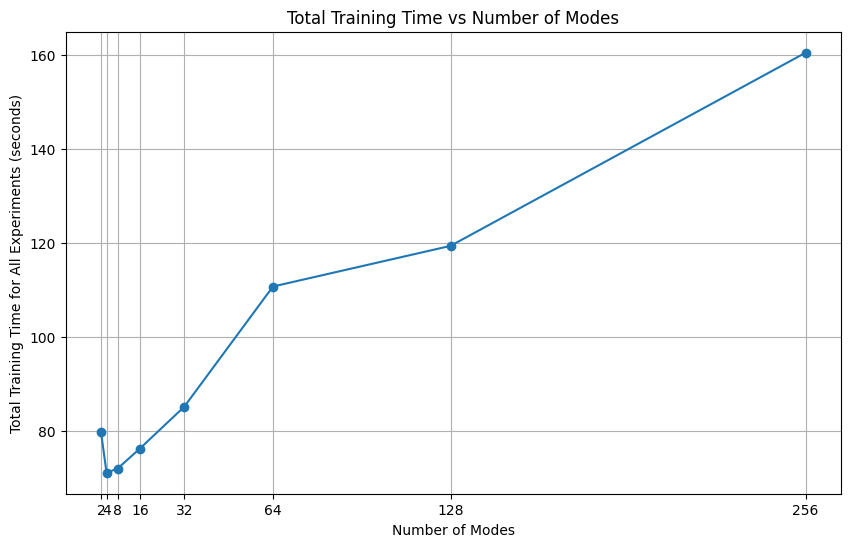

In [43]:
import json
import matplotlib.pyplot as plt

file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]

def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

def process_file_all_experiments(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        total_time = sum(exp['training_info']['experiment_time'] for exp in data.values())
        return total_time

modes = [2, 4, 8, 16, 32, 64, 128, 256]
total_times_all_experiments = []

for file_name in file_names:
    total_times_all_experiments.append(process_file_all_experiments(file_name)) 

plt.figure(figsize=(10, 6))
plt.plot(modes, total_times_all_experiments, marker='o')
plt.xticks(modes)
plt.xlabel('Number of Modes')
plt.ylabel('Total Training Time for All Experiments (seconds)')
plt.title('Total Training Time vs Number of Modes')
plt.grid(True)
plt.show()

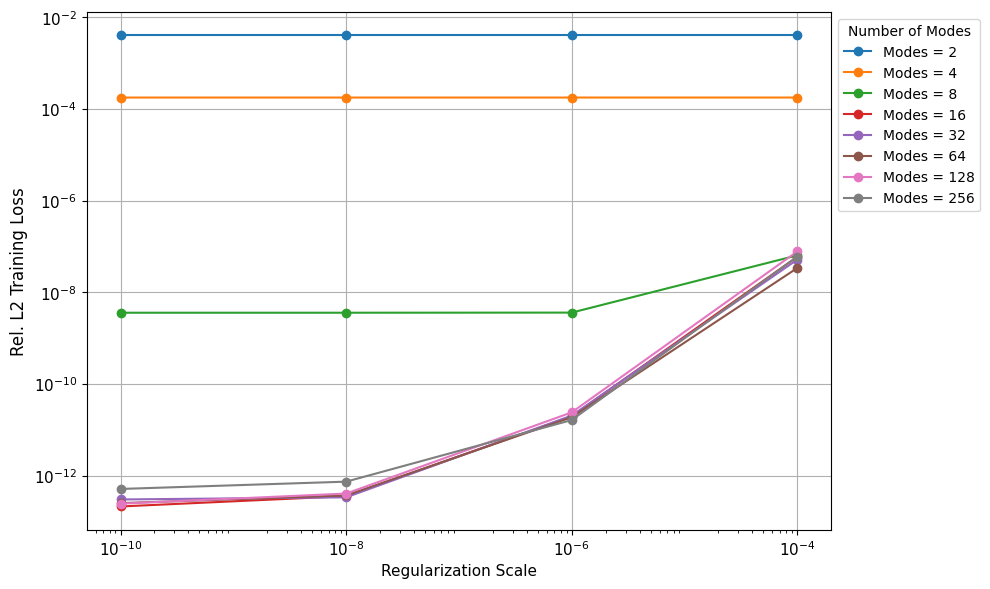

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File names
file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]

def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

fig, ax = plt.subplots(figsize=(10, 6))

x_ticks = [10**-10, 10**-8, 10**-6, 10**-4]

for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        reg_loss_dict = {}

        for exp_key, exp in data.items():
            reg_scale = exp['trunk_config']['linear_layer']['regularization_scale']
            iteration_losses = [value for key, value in exp['training_info'].items() if 'loss' in key]
            best_loss = min(iteration_losses)
            
            if reg_scale in x_ticks:
                if reg_scale not in reg_loss_dict:
                    reg_loss_dict[reg_scale] = best_loss
                else:
                    reg_loss_dict[reg_scale] = min(reg_loss_dict[reg_scale], best_loss)

        sorted_keys = sorted(reg_loss_dict.keys())
        sorted_values = [reg_loss_dict[key] for key in sorted_keys]
        
        ax.plot(sorted_keys, sorted_values, marker='o', label=f'Modes = {extract_modes(file_name)}')

ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xlabel('Regularization Scale', fontsize=11)
ax.set_ylabel('Rel. L2 Training Loss', fontsize=12)
ax.grid(True)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=11)

ax.legend(title="Number of Modes", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

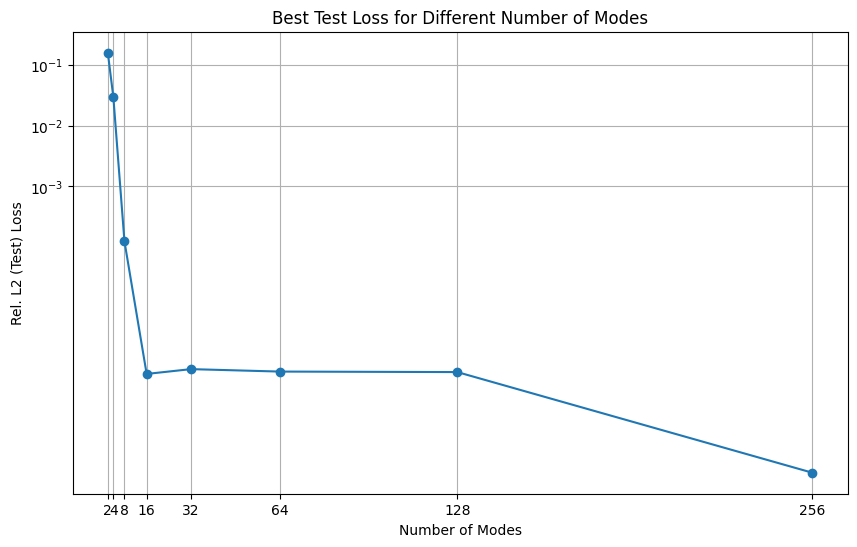

In [5]:
import json
import matplotlib.pyplot as plt

file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]

def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

modes = []
best_test_losses_with_exp_num = []
layer_info = []

for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        mode = extract_modes(file_name)
        modes.append(mode)

        best_loss_exp_number = None
        min_loss = float('inf')
        best_layer_width = None
        best_activation = None

        for exp_number, exp in data.items():
            if all(exp['training_info']['is_converged_values']):
                if exp['test_info']['test_loss_after_training'] < min_loss:
                    min_loss = exp['test_info']['test_loss_after_training']
                    best_loss_exp_number = exp_number
                    best_layer_width = exp['branch_config']['dense_layer']['layer_width']
                    best_activation = exp['branch_config']['dense_layer']['activation']

        best_test_losses_with_exp_num.append((min_loss, best_loss_exp_number))
        layer_info.append((best_layer_width, best_activation))

best_test_losses = [loss for loss, exp_num in best_test_losses_with_exp_num]

plt.figure(figsize=(10, 6))
plt.plot(modes, best_test_losses, marker='o')

plt.xlabel('Number of Modes')
plt.ylabel('Rel. L2 (Test) Loss')
plt.title('Best Test Loss for Different Number of Modes')
plt.xticks(modes)
plt.yscale('log')
plt.yticks([10**-1, 10**-2, 10**-3])
plt.gca().yaxis.set_minor_locator(plt.NullLocator())
plt.grid(True)
plt.show()


In [57]:
best_test_losses_with_exp_num

[(0.15941116282515724, 'experiment_27'),
 (0.029453564150855545, 'experiment_28'),
 (0.00012397917364696204, 'experiment_28'),
 (8.112030620651871e-07, 'experiment_28'),
 (9.735331906418244e-07, 'experiment_28'),
 (8.87218231139502e-07, 'experiment_28'),
 (8.702631435585494e-07, 'experiment_28'),
 (1.9104246739118256e-08, 'experiment_28')]

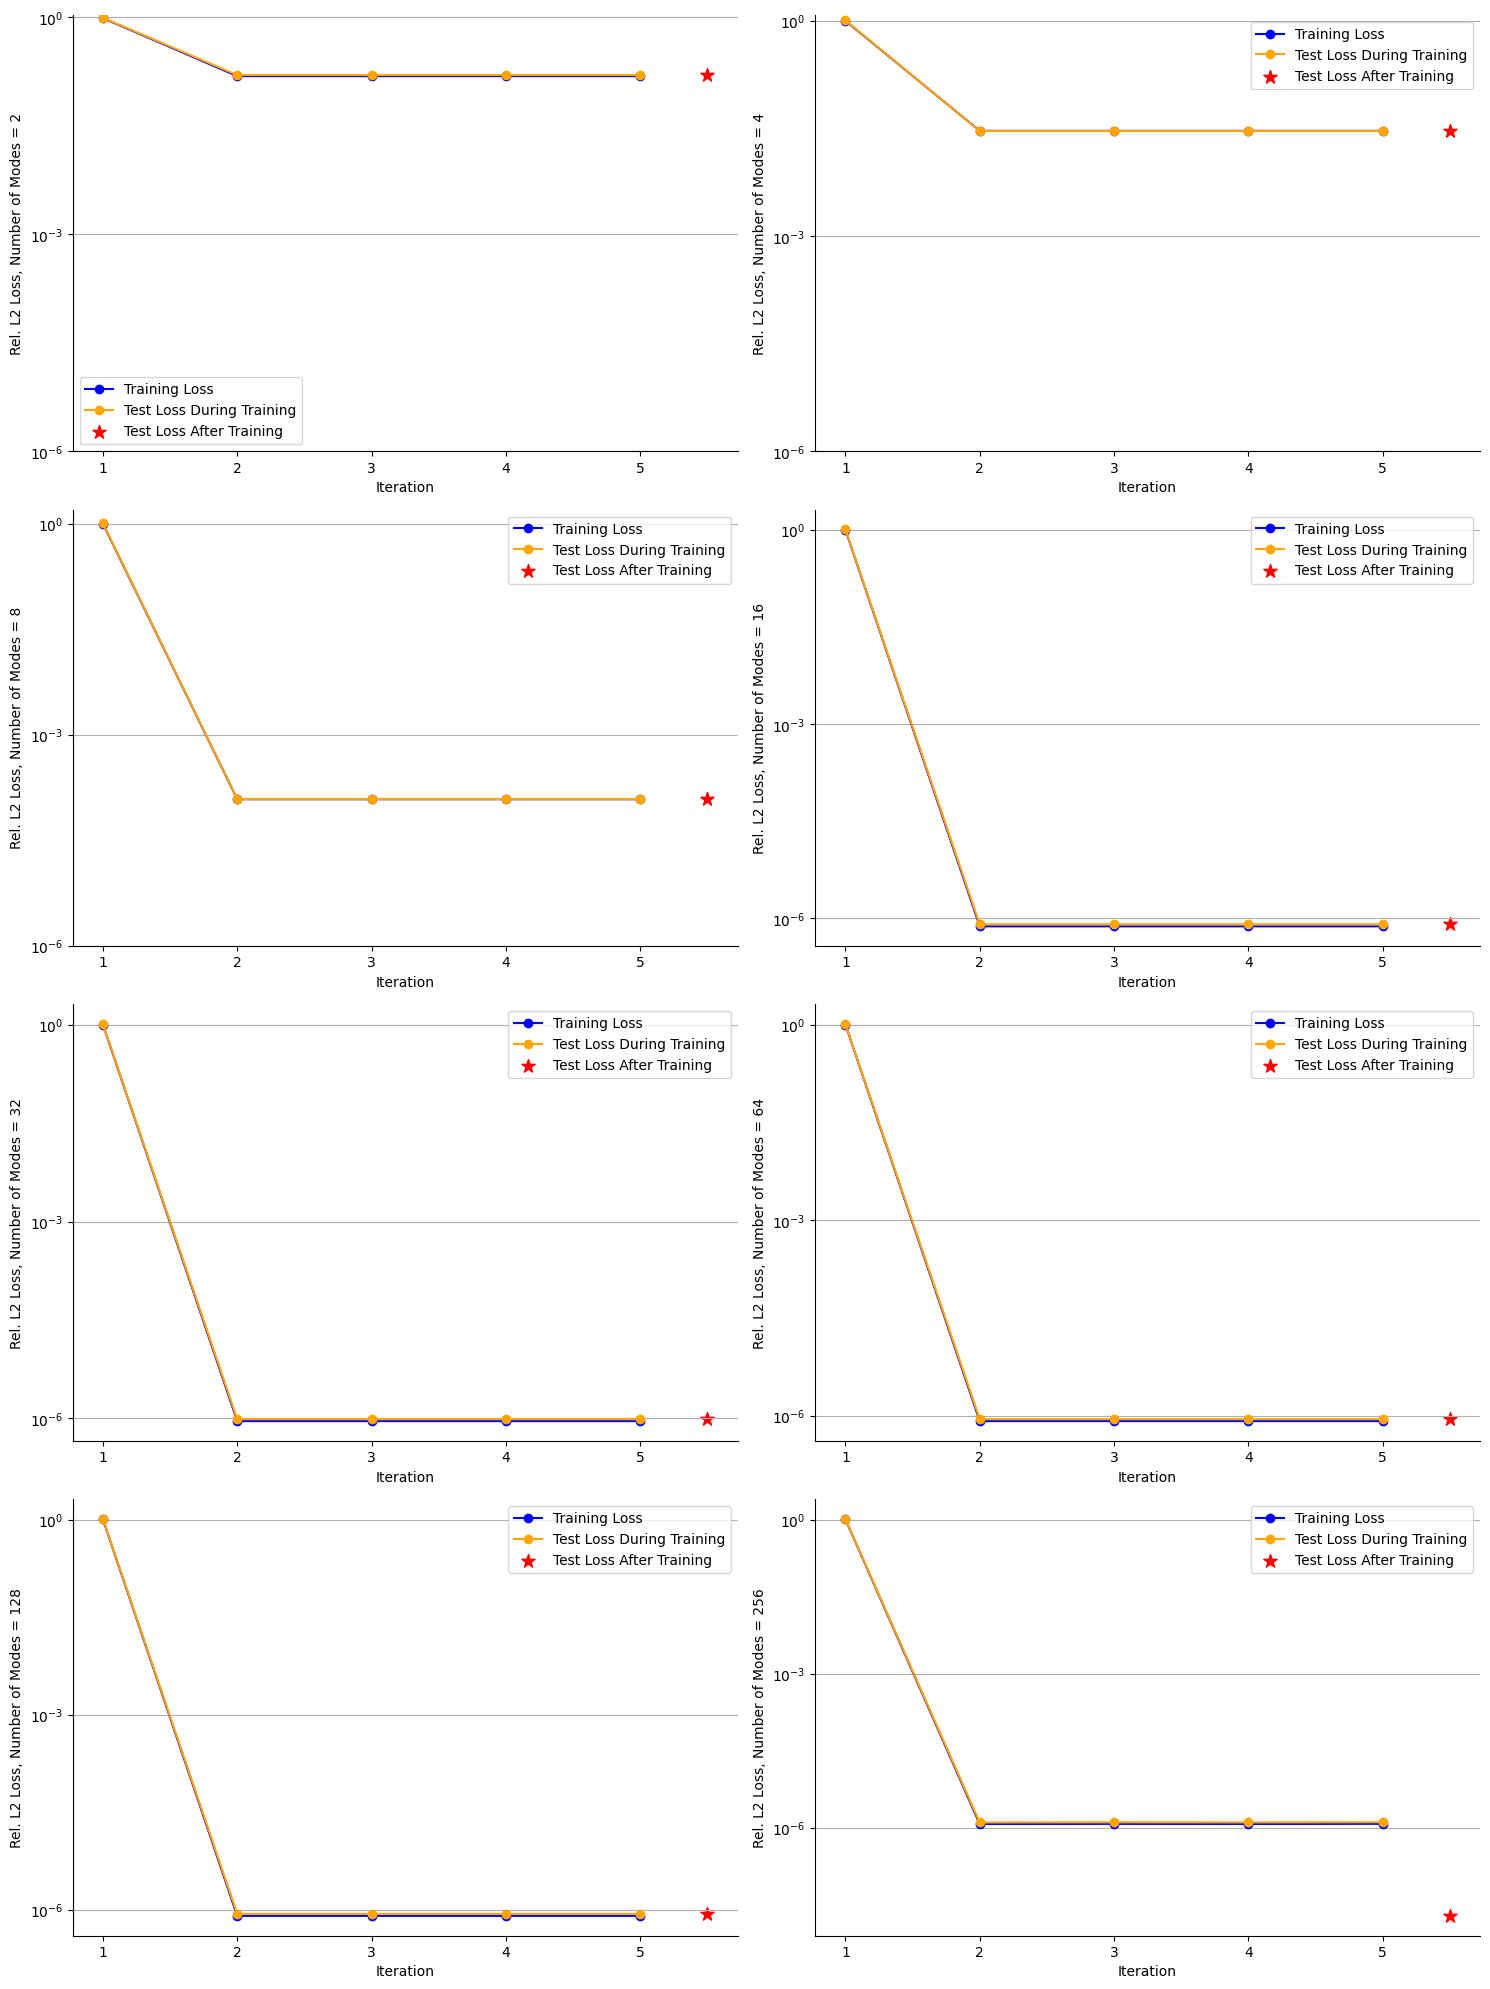

Best experiments for each file:
{}


In [67]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Define the file names
file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]
def extract_modes(file_name):
    start = file_name.find('[') + 1
    end = file_name.find(']')
    return int(file_name[start:end])

# Initialize the figure for subplots (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Dictionary to save the best experiment numbers
best_experiments = {}

# Determine global min and max loss for standardizing y-axis ticks
global_min_loss = float('inf')
global_max_loss = float('-inf')

# Process each file to find global min and max
for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        for experiment, details in data.items():
            test_loss = details['test_info']['test_loss_after_training']
            if test_loss < global_min_loss:
                global_min_loss = test_loss
            if test_loss > global_max_loss:
                global_max_loss = test_loss

# Determine the log scale ticks based on the overall min and max losses
log_min = np.floor(np.log10(global_min_loss))
log_max = np.ceil(np.log10(global_max_loss))
uniform_ticks = np.logspace(log_min, log_max, num=4)

# Plotting for each file
for i, file_name in enumerate(file_names):
    with open(file_name, 'r') as file:
        data = json.load(file)

    # Find the experiment with the lowest test loss
    best_test_loss = float('inf')
    best_experiment_number = None
    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']):
            test_loss = details['test_info']['test_loss_after_training']
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_experiment_number = experiment

    # Extract training losses for the best experiment
    best_experiment_data = data[best_experiment_number]['training_info']
    training_losses = [best_experiment_data[f'iteration_{j}_loss'] for j in range(1, 11) if f'iteration_{j}_loss' in best_experiment_data]

    # Plot the training losses in blue
    ax = axes[i]
    ax.plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='Training Loss', color='blue')

    # Extract and plot the test losses during training in orange
    test_losses = [data[best_experiment_number]['test_info'][f'iteration_{j}_test_loss'] for j in range(1, 11) if f'iteration_{j}_test_loss' in data[best_experiment_number]['test_info']]
    ax.plot(range(1, len(test_losses) + 1), test_losses, marker='o', color='orange', label='Test Loss During Training')
    
    # Plot the 'test_loss_after_training' value with a different marker
    ax.scatter(len(training_losses) + 0.5, best_test_loss, marker='*', color='red', s=100, label='Test Loss After Training')
    #ax.annotate('Test Loss After\nTraining', (len(training_losses) + 0.5, best_test_loss), textcoords="offset points", xytext=(10,-10), ha='center')

    ax.set_xlabel('Iteration')
    ax.set_ylabel(f'Rel. L2 Loss, Number of Modes = {extract_modes(file_name)}')
    ax.set_yscale('log')
    ax.set_yticks([1, 10**-3, 10**-6])
    ax.get_yaxis().set_major_formatter(ticker.LogFormatterMathtext())
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(1, 11))) 

    # Clean up axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True)  # Only horizontal grid lines
    ax.xaxis.grid(False)
    ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Output the dictionary of best experiments
print("Best experiments for each file:")
print(best_experiments)


In [63]:
training_losses

[1.0272033726912249,
 1.2611407381398969e-06,
 1.2692115061435796e-06,
 1.263871317097165e-06,
 1.2739708285164824e-06]

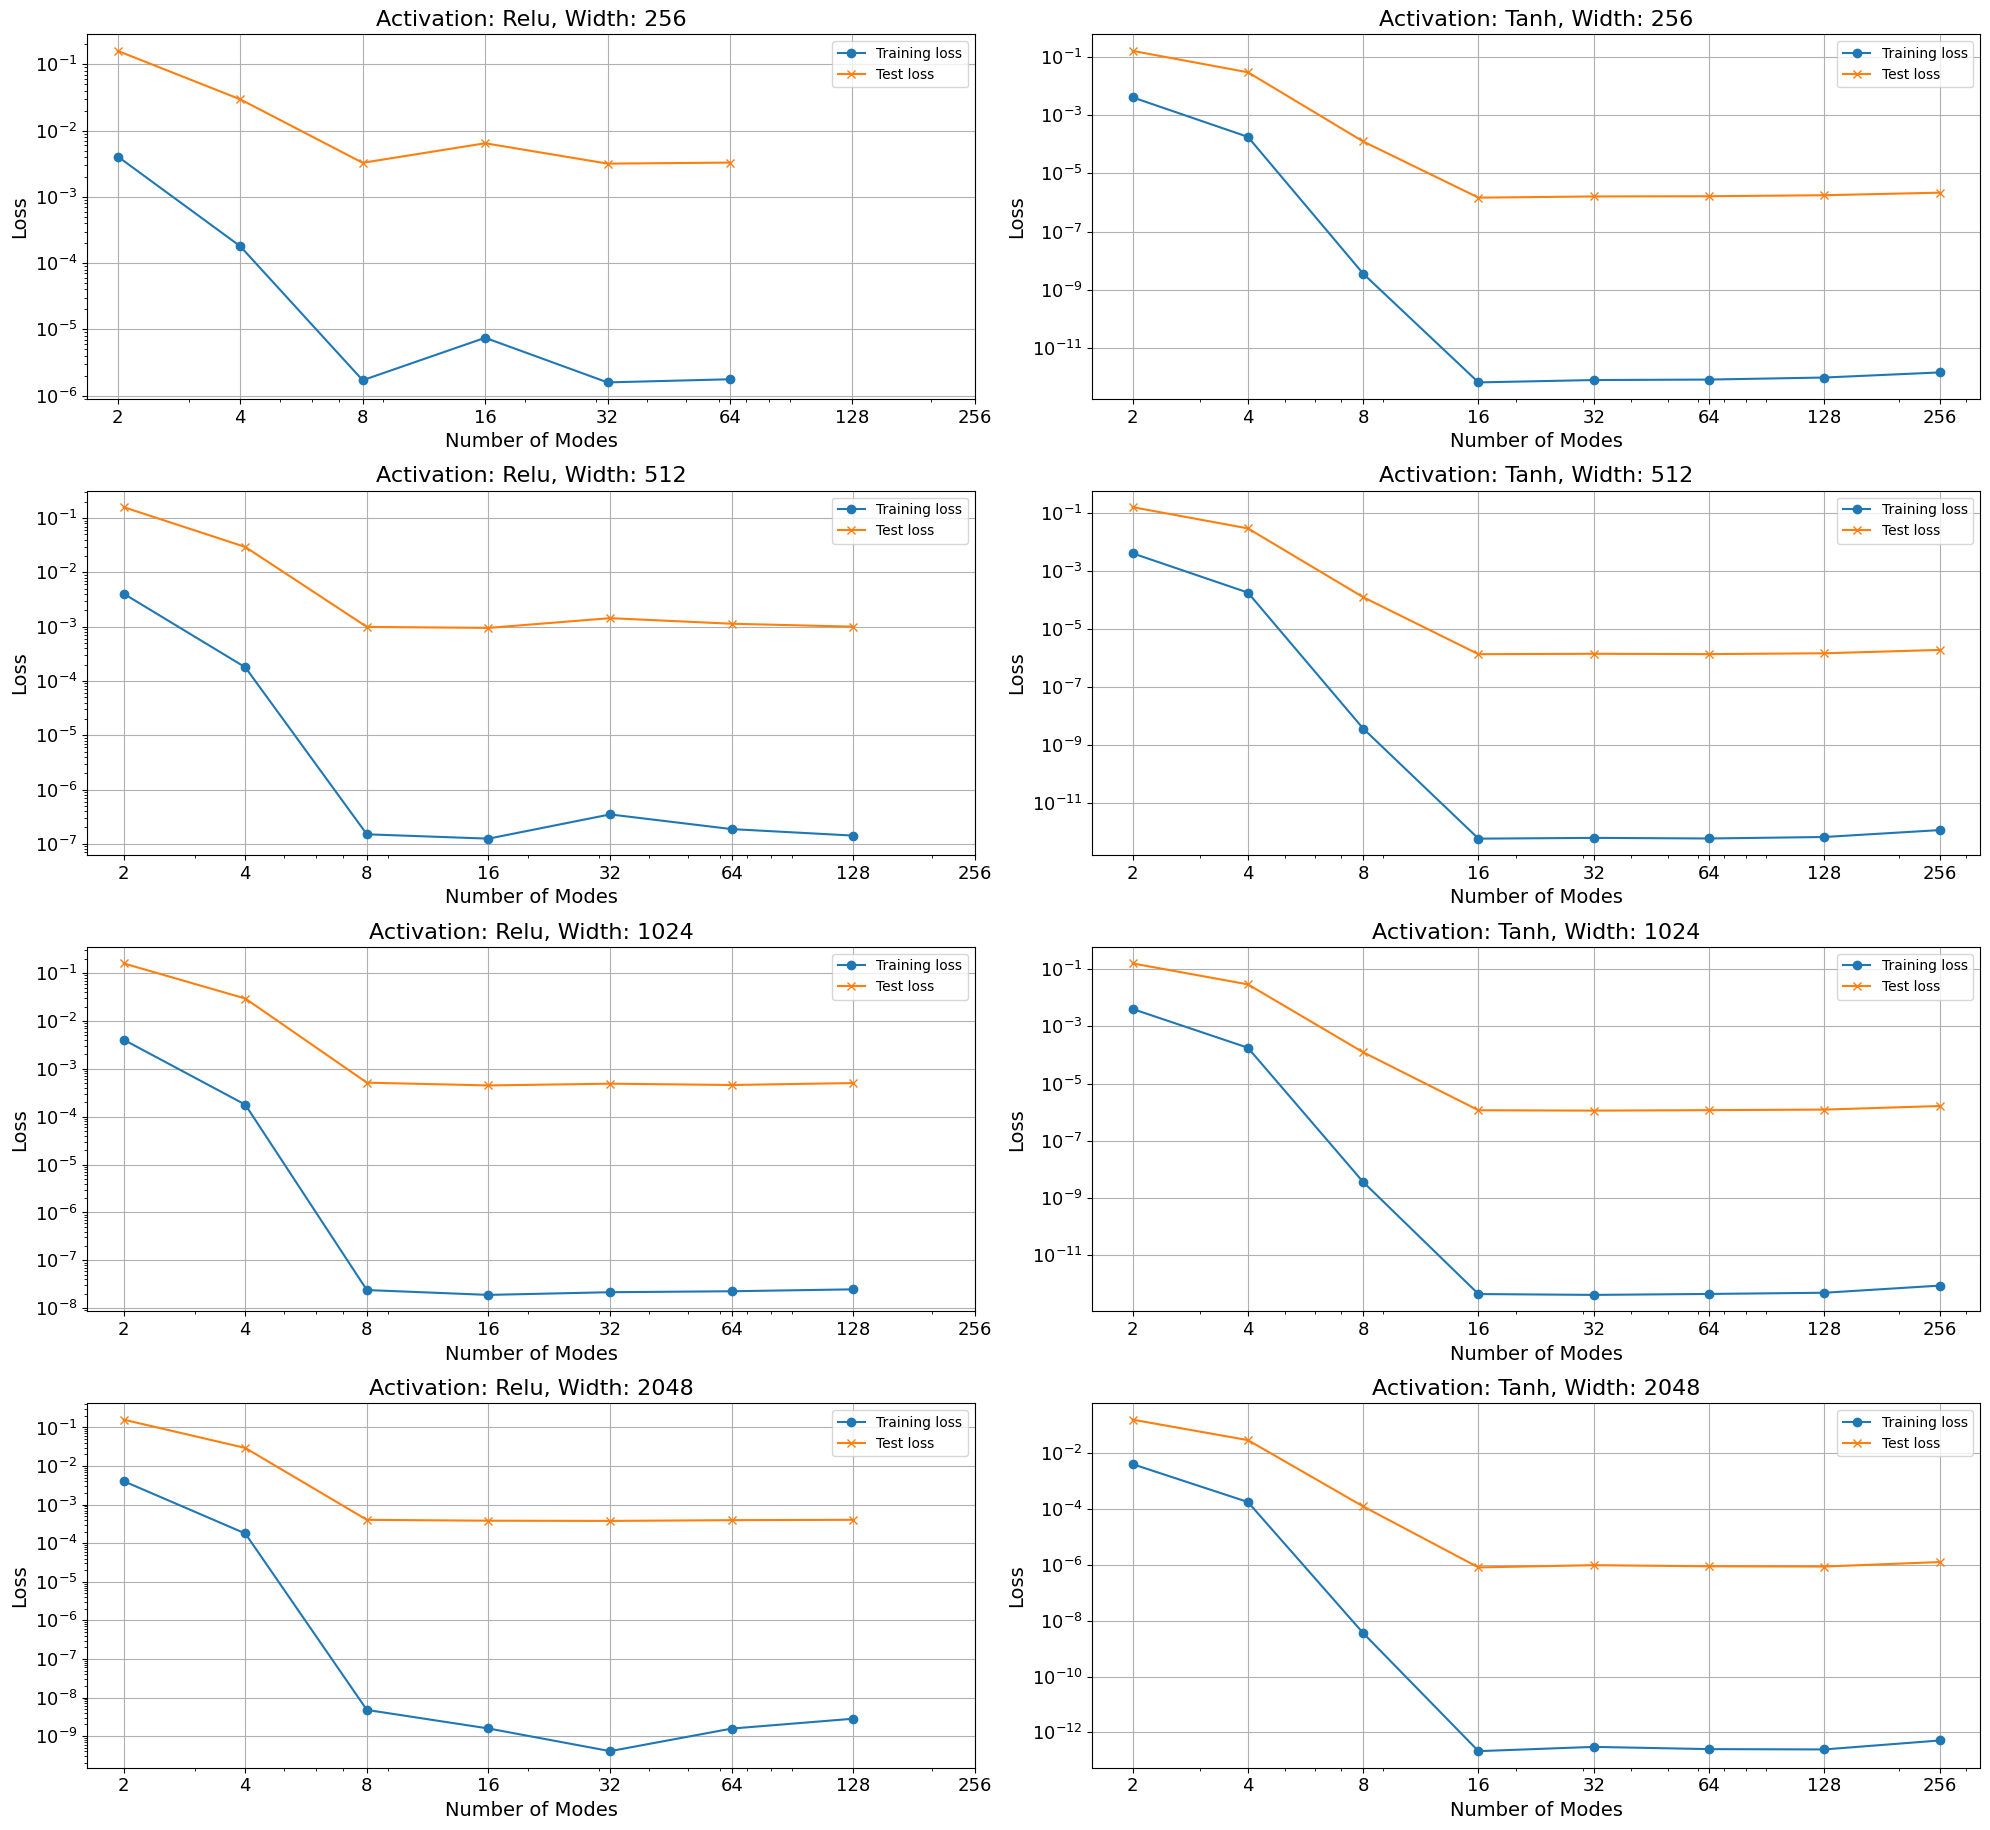

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np

# List of file names
file_names = [
    "wave_results_n_[2]_avg.json",
    "wave_results_n_[4]_avg.json",
    "wave_results_n_[8]_avg.json",
    "wave_results_n_[16]_avg.json",
    "wave_results_n_[32]_avg.json",
    "wave_results_n_[64]_avg.json",
    "wave_results_n_[128]_avg.json",
    "wave_results_n_[256]_avg.json"
]

n_rows = 4  # Four rows
n_cols = 2  # Two columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

configs = ['relu-256', 'relu-512', 'relu-1024', 'relu-2048', 'tanh-256', 'tanh-512', 'tanh-1024', 'tanh-2048']
train_losses = {config: {mode: float('inf') for mode in [2, 4, 8, 16, 32, 64, 128, 256]} for config in configs}
test_losses = {config: {mode: float('inf') for mode in [2, 4, 8, 16, 32, 64, 128, 256]} for config in configs}

for file_name in file_names:
    n_modes = int(file_name.split('_')[3].strip('[]'))
    with open(file_name) as file:
        data = json.load(file)

    for experiment, details in data.items():
        if all(details['training_info']['is_converged_values']):
            layer_width = details['branch_config']['dense_layer']['layer_width']
            activation = details['branch_config']['dense_layer']['activation']
            
            # Find the best training loss configuration
            min_loss = float('inf')
            min_iteration = None
            for key, value in details['training_info'].items():
                if key.startswith('iteration_') and key.endswith('_loss') and value > 0 and value < min_loss:
                    min_loss = value
                    min_iteration = int(key.split('_')[1])
            
            config_name = f"{activation}-{layer_width}"
            if config_name in configs:
                train_losses[config_name][n_modes] = min_loss
                
                if min_iteration is not None:
                    # Extract corresponding test loss
                    test_loss_key = f"iteration_{min_iteration}_test_loss"
                    test_loss = details['test_info'].get(test_loss_key, float('inf'))
                    test_losses[config_name][n_modes] = test_loss

# Plotting
mode_values = [2, 4, 8, 16, 32, 64, 128, 256]
relu_configs = ['relu-256', 'relu-512', 'relu-1024', 'relu-2048']
tanh_configs = ['tanh-256', 'tanh-512', 'tanh-1024', 'tanh-2048']

for i, config in enumerate(relu_configs + tanh_configs):
    # Determine which side (left or right) to plot
    column_index = 0 if config in relu_configs else 1

    ax = axes[i % n_rows, column_index]
    sorted_train_losses = [train_losses[config][mode] for mode in mode_values if train_losses[config][mode] < float('inf')]
    sorted_test_losses = [test_losses[config][mode] for mode in mode_values if test_losses[config][mode] < float('inf')]
    
    ax.plot(mode_values[:len(sorted_train_losses)], sorted_train_losses, label=f'Training loss', marker='o')
    ax.plot(mode_values[:len(sorted_test_losses)], sorted_test_losses, label=f'Test loss', marker='x')

    ax.set_xscale('log')
    ax.set_xticks(mode_values)
    ax.set_xticklabels([str(m) for m in mode_values])
    ax.set_xlabel('Number of Modes', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_yscale('log')

    # Extract activation and width for title
    activation, width = config.split('-')
    ax.set_title(f"Activation: {activation.capitalize()}, Width: {width}", fontsize=16)

    ax.tick_params(axis='both', labelsize=13)
    ax.grid(True)

# Adding a legend
for ax in axes.flat:
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


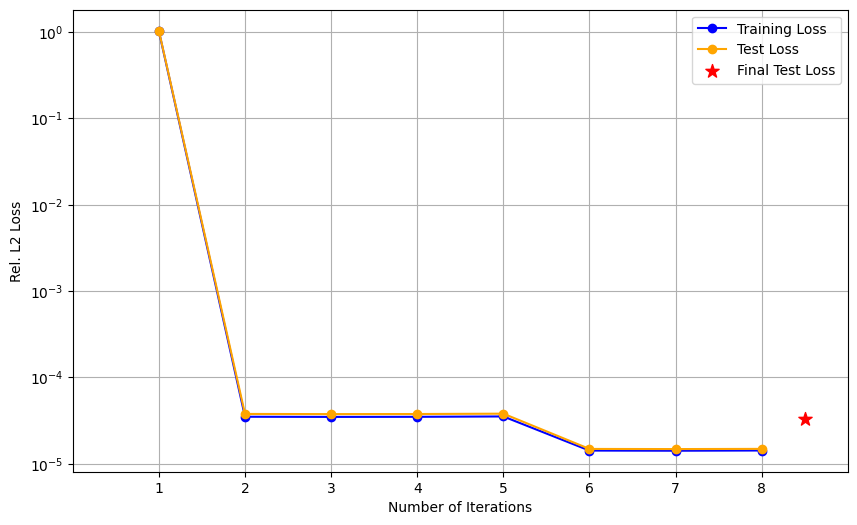

In [79]:
import json
import matplotlib.pyplot as plt


with open('wave_results_n_[128]_avg.json', 'r') as file:
    data = json.load(file)


experiment_data = data['experiment_2']
training_info = experiment_data['training_info']
test_info = experiment_data['test_info']


iterations = range(1, 9) 
training_losses = [training_info[f'iteration_{i}_loss'] for i in iterations]
test_losses = [test_info[f'iteration_{i}_test_loss'] for i in iterations]
final_test_loss = test_info['test_loss_after_training']

plt.figure(figsize=(10, 6))
plt.plot(iterations, training_losses, label='Training Loss', color='blue', marker='o')
plt.plot(iterations, test_losses, label='Test Loss', color='orange', marker='o')
plt.scatter([8.5], [final_test_loss], color='red', marker='*', s=100, label='Final Test Loss')  # Red star at x = 8.5
plt.xlabel('Number of Iterations')
plt.ylabel('Rel. L2 Loss')
plt.tick_params(axis='y', which='minor', left=False)
plt.xticks(iterations)
plt.xlim(0, 9)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()